# Intro
### Loading librarier, data and creating functions

In [1]:
#importing nessesary libraries
import pandas as pd
import pypsa
import urllib3
import plotly.graph_objects as go
import calendar
urllib3.disable_warnings()
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px


In [2]:
# Load Technology data
year = 2025
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])
#costs = pd.read_csv('Data/costs_2025.csv', sep=',', index_col=[0,1])

#Converting kW to MW
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

#Setting marginal costs
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]


In [3]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n


In [4]:
annuity = costs.apply(lambda x: annuity(x["lifetime"], x["discount rate"]), axis=1)
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

In [5]:
print("Capital cost for onshore wind:", costs.at["onwind", "capital_cost"])
print("Capital cost for solar:", costs.at["solar", "capital_cost"])
print("Capital cost for OCGT:", costs.at["OCGT", "capital_cost"])
print("Capital cost for coal:", costs.at["coal", "capital_cost"])
print("Capital cost for offshore wind:", costs.at["offwind", "capital_cost"])
print("Capital cost for oil:", costs.at["oil", "capital_cost"])
print("Capital cost for biomass:", costs.at["biomass", "capital_cost"])

print("MC gas", costs.at["gas", "marginal_cost"])
print("MC OCGT", costs.at["OCGT", "marginal_cost"])
print("MC coal", costs.at["coal", "marginal_cost"])
print("MC biomass", costs.at["biomass", "marginal_cost"])
print("MC oil", costs.at["oil", "marginal_cost"])

Capital cost for onshore wind: 107441.45702058321
Capital cost for solar: 63114.92398493304
Capital cost for OCGT: 48739.697512920015
Capital cost for coal: 337208.02744802914
Capital cost for offshore wind: 184567.39355010682
Capital cost for oil: 40272.798145584995
Capital cost for biomass: 294201.05117025424
MC gas 24.568
MC OCGT 65.42372839506173
MC coal 30.098840449438203
MC biomass 15.828205128205129
MC oil 157.52387142857143


In [6]:
#Initializing the network
network = pypsa.Network()

In [7]:
# The following function will be used to create the network, add the components and run the optimization
def optimizer(year, co2_limit=None):
    
    if co2_limit is not None:
        network.add("GlobalConstraint",
                    "co2_limit",
                    type="primary_energy",
                    carrier_attribute="co2_emissions",
                    sense="<=",
                    constant=co2_limit,
                    overwrite=True)
        

    hours_in_year = pd.date_range(f'{year}-01-01 00:00Z',
                                f'{year}-12-31 23:00Z',
                                freq='h')

    network.set_snapshots(hours_in_year.values)

    # add the electricity bus
    network.add("Bus",
                "electricity bus", overwrite=True)

    # load electricity demand data
    df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
    df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
    
    #Selecting Ireland
    country='IRL'
    

    # add load to the bus
    network.add("Load",
        "load",
        bus="electricity bus",
        p_set=df_elec[country].values,
        overwrite=True)
    

    # add the different carriers
    network.add("Carrier", "gas", co2_emissions= costs.at["gas", "CO2 intensity"], overwrite=True) # in t_CO2/MWh_th
    network.add("Carrier", "onshorewind", overwrite=True)
    network.add("Carrier", "solar", overwrite=True)
    network.add("Carrier", "coal", co2_emissions = costs.at["coal", "CO2 intensity"], overwrite=True) # in t_CO2/MWh_th
    network.add("Carrier", "biomass", co2_emissions = costs.at["biomass", "CO2 intensity"], overwrite=True) # in t_CO2/MWh_th
    network.add("Carrier", "oil", co2_emissions = costs.at["oil", "CO2 intensity"], overwrite=True) # in t_CO2/MWh_th
    network.add("Carrier", "offshorewind", overwrite=True)

    # add onshore wind generator
    df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
    df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
    CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
    network.add("Generator",
                "onshorewind",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="onshorewind",
                p_nom_max=4810-25.2, # maximum capacity can be limited due to environmental constraints. Based on electricity maps - minus the off shore wind capacity
                capital_cost =costs.at["onwind", "capital_cost"] , # in €/MW
                marginal_cost = 0,
                p_max_pu = CF_wind.values,
                overwrite=True)

    # add solar PV generator
    df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
    df_solar.index = pd.to_datetime(df_solar.index)
    CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
    network.add("Generator",
                "solar",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="solar",
                p_nom_max = 740, # maximum capacity can be limited due to environmental constraints Based on electricity maps
                capital_cost = costs.at["solar", "capital_cost"], # in €/MW
                marginal_cost = 0,
                p_max_pu = CF_solar.values,
                overwrite=True)

    # add OCGT (Open Cycle Gas Turbine) generator
    network.add("Generator",
                "OCGT",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="gas",
                p_nom_max=4270, #based on electricity maps
                capital_cost = costs.at["OCGT", "capital_cost"], #in €/MW
                marginal_cost = costs.at["OCGT", "marginal_cost"],
                overwrite=True)

    # add Coal generator
    network.add("Generator",
                "Coal",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="coal",
                p_nom_max=920, #based on electricity maps
                capital_cost = costs.at["coal", "capital_cost"], #in €/MW
                marginal_cost = costs.at["coal", "marginal_cost"],
                overwrite=True)

    # add biomass generator
    network.add("Generator",
                "Biomass",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="biomass",
                p_nom_max=70, #based on electricity maps 
                capital_cost = costs.at["biomass", "capital_cost"], #in €/MW
                marginal_cost = costs.at["biomass", "marginal_cost"],
                overwrite=True)

    # add oil generator
    network.add("Generator",
                "Oil",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="oil",
                p_nom_max=830, #based on electricity maps
                capital_cost = costs.at["oil", "capital_cost"], #in €/MW
                marginal_cost = costs.at["oil", "marginal_cost"],
                overwrite=True)

    # add offshore wind generator
    df_offshorewind = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
    df_offshorewind.index = pd.to_datetime(df_offshorewind.index)
    CF_offshorewind = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
    network.add("Generator",
                "offshorewind",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="offshorewind",
                p_nom_max=25.2, # maximum capacity can be limited due to environmental constraints. #Ireland doesnt have offshore wind today, but are proposing to install 5GW soon
                capital_cost = costs.at["offwind", "capital_cost"], # in €/MW
                marginal_cost = 0,
                p_max_pu = CF_offshorewind.values,
                overwrite=True)
    

    #Optimization
    status = network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})


    objective = network.objective #in €
    capacities = network.generators.p_nom_opt #in MW
    loadConsumption = network.loads_t.p
    generation = network.generators_t.p
    snapshots = network.snapshots
    
    
    

    return objective, capacities, loadConsumption, generation, snapshots, status




# Task A)


In [8]:
#The network is optimized for 2015 with no CO2 limit, in order to get the optimal capacities
objective, capacities, loadConsumption, generation, snapshot, status = optimizer(2015, None)

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 49.57it/s]
INFO:linopy.io: Writing time: 0.29s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-wc_k6u8n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-wc_k6u8n.lp


Reading time = 0.11 seconds


INFO:gurobipy:Reading time = 0.11 seconds


obj: 131414 rows, 61327 columns, 240914 nonzeros


INFO:gurobipy:obj: 131414 rows, 61327 columns, 240914 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131414 duals
Objective: 1.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


### Optimal dispatch for first week of january 2015 and first week of july 2015

In [9]:

def plot_dispatch_summer_and_winter():
    fig = make_subplots(rows=1, cols=2, shared_xaxes=False, horizontal_spacing=0.1, 
                        subplot_titles=("Winter dispatch", "Summer dispatch"))

    # First subplot
    fig.add_trace(go.Scatter(x=snapshot[:168], y=loadConsumption['load'][:168], mode='lines', name='demand', line=dict(color='black')), row=1, col=1)
    fig.add_trace(go.Scatter(x=snapshot[:168], y=generation['onshorewind'][:168], mode='lines', name='onshore wind', line=dict(color='blue')), row=1, col=1)
    fig.add_trace(go.Scatter(x=snapshot[:168], y=generation['solar'][:168], mode='lines', name='solar', line=dict(color='orange')), row=1, col=1)
    fig.add_trace(go.Scatter(x=snapshot[:168], y=generation['OCGT'][:168], mode='lines', name='gas (OCGT)', line=dict(color='brown')), row=1, col=1)
    fig.add_trace(go.Scatter(x=snapshot[:168], y=generation['Coal'][:168], mode='lines', name='coal', line=dict(color='grey')), row=1, col=1)
    fig.add_trace(go.Scatter(x=snapshot[:168], y=generation['Biomass'][:168], mode='lines', name='biomass', line=dict(color='green')), row=1, col=1)
    fig.add_trace(go.Scatter(x=snapshot[:168], y=generation['Oil'][:168], mode='lines', name='oil', line=dict(color='black')), row=1, col=1)
    fig.add_trace(go.Scatter(x=snapshot[:168], y=generation['offshorewind'][:168], mode='lines', name='offshore wind', line=dict(color='purple')), row=1, col=1)

    # Second subplot
    fig.add_trace(go.Scatter(x=snapshot[4344:4512], y=loadConsumption['load'][4344:4512], mode='lines', showlegend=False, line=dict(color='black')), row=1, col=2)
    fig.add_trace(go.Scatter(x=snapshot[4344:4512], y=generation['onshorewind'][4344:4512], mode='lines', showlegend=False, line=dict(color='blue')), row=1, col=2)
    fig.add_trace(go.Scatter(x=snapshot[4344:4512], y=generation['solar'][4344:4512], mode='lines', showlegend=False, line=dict(color='orange')), row=1, col=2)
    fig.add_trace(go.Scatter(x=snapshot[4344:4512], y=generation['OCGT'][4344:4512], mode='lines', showlegend=False, line=dict(color='brown')), row=1, col=2)
    fig.add_trace(go.Scatter(x=snapshot[4344:4512], y=generation['Coal'][4344:4512], mode='lines', showlegend=False, line=dict(color='grey')), row=1, col=2)
    fig.add_trace(go.Scatter(x=snapshot[4344:4512], y=generation['Biomass'][4344:4512], mode='lines', showlegend=False, line=dict(color='green')), row=1, col=2)
    fig.add_trace(go.Scatter(x=snapshot[4344:4512], y=generation['Oil'][4344:4512], mode='lines', showlegend=False, line=dict(color='black')), row=1, col=2)
    fig.add_trace(go.Scatter(x=snapshot[4344:4512], y=generation['offshorewind'][4344:4512], mode='lines', showlegend=False, line=dict(color='purple')), row=1, col=2)

    fig.update_layout(height=600, width=1200, yaxis_title='Power (MW)', 
                      legend=dict(x=0.5, y=-0.2, traceorder='normal', orientation='h', xanchor='center', yanchor='top'))
    fig.show()
    #save plot as pdf
    fig.write_image("Plots/dispatch.pdf", format="pdf", width=1200, height=600)

plot_dispatch_summer_and_winter()

/Users/andreasthrane/anaconda3/envs/Integrated/lib/python3.11/site-packages/kaleido/scopes/base.py:188: DeprecationWarning:

setDaemon() is deprecated, set the daemon attribute instead



### Plot the duration curve and electricity mix for entirety of 2015

In [10]:
# Renaming labels
rename_map = {
    'onshorewind': 'Onshore Wind',
    'solar': 'Solar',
    'OCGT': 'Gas (OCGT)',
    'Coal': 'Coal',
    'Biomass': 'Biomass',
    'Oil': 'Oil',
    'offshorewind': 'Offshore Wind'
}
generation_renamed = generation.rename(columns=rename_map)

#Sort by total generation (descending)
sorted_idx = generation_renamed.sum(axis=1).sort_values(ascending=False).index
generation_sorted = generation_renamed.loc[sorted_idx].reset_index(drop=True)

# Melt to long format
generation_melted = generation_sorted.melt(
    var_name='Technology',
    value_name='Generation',
    ignore_index=False
)
generation_melted['Hour'] = generation_melted.index // len(generation_renamed.columns)

# Define color palette
color_map = {
    'Onshore Wind': 'blue',
    'Solar': 'orange',
    'Gas (OCGT)': 'brown',
    'Coal': 'grey',
    'Biomass': 'green',
    'Oil': 'black',
    'Offshore Wind': 'purple'
}

# Create area plot
area_fig = px.area(
    generation_melted,
    x='Hour',
    y='Generation',
    color='Technology',
    labels={'Generation': 'Electricity Generation (MW)', 'Hour': 'Hour (sorted by demand)'},
    color_discrete_map=color_map
)

# Create subplots
fig = make_subplots(
    rows=1,
    cols=2,
    column_widths=[0.75, 0.25], 
    #subplot_titles=("Load Duration Curve", "Electricity Mix"),
    specs=[[{"type": "scatter"}, {"type": "domain"}]]
)

# Add area plot
for trace in area_fig.data:
    trace.showlegend = False
    trace.line.width = 0
    fig.add_trace(trace, row=1, col=1)

# Pie chart data
colors = list(color_map.values())
labels = list(rename_map.values())
sizes = [generation[col].sum() for col in rename_map.keys()]

# Add pie chart
fig.add_trace(
    go.Pie(
    labels=labels,
    values=sizes,
    marker=dict(colors=colors),
    showlegend=True,
    sort=False,
    direction='clockwise',
    rotation=180,
    textinfo='label+percent',
    legendgroup='Electricity',
    # This part helps distribute items more horizontally
    domain=dict(x=[0.75, 1.0], y=[0.25, 1.0])  # Adjust to free up space for legend
    ),
    row=1,
    col=2
)

# Update layout
fig.update_layout(
    height=500,
    width=1100,
    hovermode='x unified',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.3,
        xanchor="center",
        x=0.4,
        traceorder="normal"
    )
)

fig.update_xaxes( row=1, col=1)
fig.update_yaxes( row=1, col=1)



# Show and export
fig.show()
fig.write_image("Plots/electricity_mix.pdf", format="pdf", width=1100, height=500)


/Users/andreasthrane/anaconda3/envs/Integrated/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



# Task B)

In [11]:
def plot_dispatch_winter():
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=snapshot[:168], y=loadConsumption['load'][:168], mode='lines', name='demand', line=dict(color='black')))
    fig.add_trace(go.Scatter(x=snapshot[:168], y=generation['onshorewind'][:168], mode='lines', name='onshore wind', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=snapshot[:168], y=generation['solar'][:168], mode='lines', name='solar', line=dict(color='orange')))
    fig.add_trace(go.Scatter(x=snapshot[:168], y=generation['OCGT'][:168], mode='lines', name='gas (OCGT)', line=dict(color='brown')))
    fig.add_trace(go.Scatter(x=snapshot[:168], y=generation['Coal'][:168], mode='lines', name='coal', line=dict(color='grey')))
    fig.add_trace(go.Scatter(x=snapshot[:168], y=generation['Biomass'][:168], mode='lines', name='biomass', line=dict(color='green')))
    fig.add_trace(go.Scatter(x=snapshot[:168], y=generation['Oil'][:168], mode='lines', name='oil', line=dict(color='black')))
    fig.add_trace(go.Scatter(x=snapshot[:168], y=generation['offshorewind'][:168], mode='lines', name='offshore wind', line=dict(color='purple')))

    fig.update_layout(#title='Electricity Dispatch Week 1 2015',
                    xaxis_title='Time',
                    yaxis_title='Power (MW)',
                    legend=dict(x=0, y=1, traceorder='normal'))

    fig.show()

In [12]:
objective, capacities, loadConsumption, generation, snapshot, staus = optimizer(2015, 2730000)
plot_dispatch_winter()

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 53.04it/s]
INFO:linopy.io: Writing time: 0.28s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-ws0plru_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-ws0plru_.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


In [13]:
objectives = {}
capacities_dic = {}
loadConsumptions = {}
generations = {}
snapshots = {}
for Co2_limit in range(2730000, 2900000, 30000):
    objective, capacities, loadConsumption, generation, snapshot, status = optimizer(2015, Co2_limit)
    if status[1] == "optimal":
        objectives[Co2_limit] = objective
        capacities_dic[Co2_limit] = capacities
        loadConsumptions[Co2_limit] = loadConsumption
        generations[Co2_limit] = generation
        snapshots[Co2_limit] = snapshot
    

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 54.63it/s]
INFO:linopy.io: Writing time: 0.29s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-c9b2f2t_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-c9b2f2t_.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 50.39it/s]
INFO:linopy.io: Writing time: 0.28s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-1c_u7n2f.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-1c_u7n2f.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 54.47it/s]
INFO:linopy.io: Writing time: 0.28s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-cr5vwi54.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-cr5vwi54.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 50.93it/s]
INFO:linopy.io: Writing time: 0.28s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-y3qqkjvm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-y3qqkjvm.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 54.48it/s]
INFO:linopy.io: Writing time: 0.29s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-ni68omcz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-ni68omcz.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 52.67it/s]
INFO:linopy.io: Writing time: 0.28s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-_m4pek8g.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-_m4pek8g.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


In [14]:


# Create a 2-row, 3-column subplot layout
fig = make_subplots(rows=2, cols=3, 
                    specs=[[{'type': 'domain'}]*3, [{'type': 'domain'}]*3],
                    subplot_titles=[f"CO2 limit: {limit} tonCO2" for limit in objectives.keys()])

colors = ['blue', 'orange', 'brown', 'grey', 'green', 'black', 'purple']
labels = ['onshore wind', 'solar', 'gas (OCGT)', 'coal', 'biomass', 'oil', 'offshore wind']

# Add a pie chart for each CO2 limit
row, col = 1, 1
for i, co2_limit in enumerate(objectives.keys()):
    gen = generations[co2_limit]
    sizes = [
        gen['onshorewind'].sum(),
        gen['solar'].sum(),
        gen['OCGT'].sum(),
        gen['Coal'].sum(),
        gen['Biomass'].sum(),
        gen['Oil'].sum(),
        gen['offshorewind'].sum()
    ]

    fig.add_trace(go.Pie(labels=labels, values=sizes, marker=dict(colors=colors), name=str(co2_limit)),
                  row=row, col=col)

    # Update row/col
    col += 1
    if col > 3:
        col = 1
        row += 1

fig.update_layout( height=700, width=1000)
fig.show()
fig.write_image("Plots/electricity_mix_co2_constraint.pdf", format="pdf", height=700, width=1000)

Based on the above analysis, a CO2 limit of 2.80MT CO2-eq is selected

In [15]:
objective_CO2, capacities_CO2, loadConsumption_CO2, generation_CO2, snapshot_CO2, status_CO2 = optimizer(2015, 2800000)


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 51.74it/s]
INFO:linopy.io: Writing time: 0.28s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-ri81esvu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-ri81esvu.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


# C)

In this task we will use a CO2 allowance of 2.80mT

In [16]:
#Printing mean CF for onshore, offshore and solar for all years
country='IRL'
df_offshorewind = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)

# add solar PV generator
df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)

df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)

# Check the structure and summary stats of the 3 datasets
for year in range(1979, 2018):
    start = f"{year}-01-01"
    end = f"{year}-12-31 23:00:00"
    
    try:
        mean_onshore = df_onshorewind.loc[start:end, 'IRL'].mean()
        mean_offshore = df_offshorewind.loc[start:end, 'IRL'].mean()
        mean_solar = df_solar.loc[start:end, 'IRL'].mean()
        print(f"{year}: Onshore = {mean_onshore:.3f}, Offshore = {mean_offshore:.3f}, Solar = {mean_solar:.3f}")
    except KeyError:
        print(f"{year}: data missing")

1979: Onshore = 0.324, Offshore = 0.453, Solar = 0.096
1980: Onshore = 0.319, Offshore = 0.460, Solar = 0.093
1981: Onshore = 0.315, Offshore = 0.446, Solar = 0.090
1982: Onshore = 0.327, Offshore = 0.432, Solar = 0.101
1983: Onshore = 0.318, Offshore = 0.424, Solar = 0.094
1984: Onshore = 0.282, Offshore = 0.400, Solar = 0.106
1985: Onshore = 0.308, Offshore = 0.421, Solar = 0.092
1986: Onshore = 0.352, Offshore = 0.483, Solar = 0.103
1987: Onshore = 0.296, Offshore = 0.388, Solar = 0.093
1988: Onshore = 0.317, Offshore = 0.432, Solar = 0.097
1989: Onshore = 0.320, Offshore = 0.426, Solar = 0.102
1990: Onshore = 0.348, Offshore = 0.471, Solar = 0.097
1991: Onshore = 0.311, Offshore = 0.414, Solar = 0.094
1992: Onshore = 0.334, Offshore = 0.451, Solar = 0.094
1993: Onshore = 0.320, Offshore = 0.430, Solar = 0.092
1994: Onshore = 0.347, Offshore = 0.467, Solar = 0.094
1995: Onshore = 0.319, Offshore = 0.438, Solar = 0.107
1996: Onshore = 0.309, Offshore = 0.424, Solar = 0.101
1997: Onsh

In [17]:


objectives = {}
capacities_dic = {}
loadConsumptions = {}
generations = {}
snapshots = {}


for year in range(2000, 2018):
    if not calendar.isleap(year):  # only hit non-leap years
        objective, capacities, loadConsumption, generation, snapshot, status = optimizer(year, 2800000)
        if status[1] == "optimal":
            print(f"Year {year} is optimal")
            objectives[year] = objective
            capacities_dic[year] = capacities
            loadConsumptions[year] = loadConsumption
            generations[year] = generation
            snapshots[year] = snapshot



Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 53.86it/s]
INFO:linopy.io: Writing time: 0.28s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-uv2jr04f.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-uv2jr04f.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267207 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267207 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.72e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2001 is optimal


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 51.95it/s]
INFO:linopy.io: Writing time: 0.29s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-ovq7rgt1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-ovq7rgt1.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267207 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267207 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.58e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2002 is optimal


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 52.26it/s]
INFO:linopy.io: Writing time: 0.29s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-byau8fbg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-byau8fbg.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267198 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267198 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.63e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2003 is optimal


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 51.75it/s]
INFO:linopy.io: Writing time: 0.29s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-89rep4mj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-89rep4mj.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267202 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267202 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.63e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2005 is optimal


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 37.98it/s]
INFO:linopy.io: Writing time: 0.29s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-0486fl9m.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-0486fl9m.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267204 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267204 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.63e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2006 is optimal


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 54.47it/s]
INFO:linopy.io: Writing time: 0.28s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-b4xtricn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-b4xtricn.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267200 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267200 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.67e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2007 is optimal


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 52.96it/s]
INFO:linopy.io: Writing time: 0.28s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-lnpndfbb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-lnpndfbb.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267192 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267192 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.62e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2009 is optimal


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 46.94it/s]
INFO:linopy.io: Writing time: 0.32s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-1ilqhmyw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-1ilqhmyw.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267209 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267209 nonzeros
INFO:linopy.solvers:Unable to save solution file. Raised error: Unable to retrieve attribute 'X'
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 54.52it/s]
INFO:linopy.io: Writing time: 0.28s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-583o57tn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-583o57tn.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267211 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267211 nonzeros
INFO:linopy.solvers:Unable to save solution file. Raised error: Unable to retrieve attribute 'X'
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 54.05it/s]
INFO:linopy.io: Writing time: 0.29s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-ronudm9g.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-ronudm9g.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267206 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267206 nonzeros
INFO:linopy.solvers:Unable to save solution file. Raised error: Unable to retrieve attribute 'X'
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 53.53it/s]
INFO:linopy.io: Writing time: 0.28s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-qgb_g2r0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-qgb_g2r0.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267211 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267211 nonzeros
INFO:linopy.solvers:Unable to save solution file. Raised error: Unable to retrieve attribute 'X'
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 53.22it/s]
INFO:linopy.io: Writing time: 0.28s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-x4u12ekd.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-x4u12ekd.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2015 is optimal


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 54.29it/s]
INFO:linopy.io: Writing time: 0.28s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-n_1jzube.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-n_1jzube.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267204 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267204 nonzeros
INFO:linopy.solvers:Unable to save solution file. Raised error: Unable to retrieve attribute 'X'
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4



In [18]:

def plot_grouped_capacities(years):
    fig = go.Figure()

    generators = ['onshorewind', 'solar', 'OCGT', 'Coal', 'Biomass', 'Oil', 'offshorewind']

    for year in years:
        capacities = [capacities_dic[year][gen] for gen in generators]
        fig.add_trace(go.Bar(
            x=generators,
            y=capacities,
            name=str(year)
        ))

    fig.update_layout(
        #title='Installed capacity per generator type over the years',
        xaxis_title='Generator Type',
        yaxis_title='Capacity (MW)',
        barmode='group',
        legend=dict(
            orientation='h',
            x=0.5,
            xanchor='center',
            y=-0.2
        ),
        margin=dict(b=100),
        width=1000,
        height=500
    )

    fig.show()
    fig.write_image("Plots/Grouped_capacity_barplot.pdf", format='pdf', width=1000, height=500)
available_years = [year for year in range(2000, 2018) 
                   if not calendar.isleap(year) and year in capacities_dic]
plot_grouped_capacities(available_years)


# Task D)
It was decided to add a pumped hydro storage

In [19]:
#Create a new carrier
network.add("Carrier",
              "Hydro")

#Create a new bus
network.add("Bus",
          "Hydro Bus",
          carrier = "Hydro")

#Connect the Pumped Hydr Storage (PHS) to the Hydro Bus
network.add("Store",
          "PHS",
          bus = "Hydro Bus",
          e_nom_extendable = True,
          e_cyclic = True,
          e_nom_max = 240, #in MWh
          capital_cost = costs.at["Pumped-Storage-Hydro-store", "capital_cost"], 
          overwrite=True
)

#Add the link "Hydro pump" that transport energy from the electricity bus (bus0) to the Hydro bus (bus1)
#with 85% efficiency
network.add("Link",
          "Hydro pump",
          bus0 = "electricity bus",
          bus1 = "Hydro Bus",
          p_nom_extendable = True,
          efficiency = 0.85,
          capital_cost = 0, 
          overwrite=True
          )

#Add the link "Hydro turbine" that transports energy from the Hydro bus (bus0) to the electricity bus (bus1)
#with 58% efficiency
network.add("Link",
          "Hydro turbine",
          bus0 = "Hydro Bus",
          bus1 = "electricity bus",
          p_nom_extendable = True,
          efficiency = 0.9,
          capital_cost = 0,
            overwrite=True
        
          )



Index(['Hydro turbine'], dtype='object')

In [20]:

objective_hydro, capacities, loadConsumption, generation, snapshot, status = optimizer("2015", 2800000)


Index(['Hydro pump'], dtype='object', name='Link')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 112.97it/s]
INFO:linopy.io: Writing time: 0.44s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-vyul7a1i.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-vyul7a1i.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 201499 rows, 96370 columns, 416118 nonzeros


INFO:gurobipy:obj: 201499 rows, 96370 columns, 416118 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96370 primals, 201499 duals
Objective: 1.69e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


In [21]:
print("objective_optimalCO2: ", objective_CO2)
print("objective_hydro: ", objective_hydro)
print("Savings using a pumped hydro storage: ", objective_CO2 - objective_hydro)


objective_optimalCO2:  1698562436.721885
objective_hydro:  1689215862.48682
Savings using a pumped hydro storage:  9346574.235064983


In [22]:

# make a df with the difference between hours
network.stores_t.e['PHS'].diff()

storage_generation = network.stores_t.e['PHS'].diff().apply(lambda x: x if x > 0 else 0)
storage_load = network.stores_t.e['PHS'].diff().apply(lambda x: x if x < 0 else 0)

storage_load = storage_load * -1


In [23]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_dispatch_and_phs_behavior():
    # 1-week period
    week_start = pd.Timestamp('2015-01-01')
    week_end = pd.Timestamp('2015-01-20')
    mask = (snapshot >= week_start) & (snapshot < week_end)
    x_vals = snapshot[mask]

    # Subplot setup: 2 rows, shared x-axis
    fig = make_subplots(
        rows=2, cols=1, shared_xaxes=True,
        vertical_spacing=0.1,
        specs=[[{"secondary_y": False}], [{"secondary_y": True}]]
    )

    # --- TOP: Generation Stack ---
    gen_colors = {
        'onshorewind': 'blue',
        'offshorewind': 'purple',
        'solar': 'orange',
        'OCGT': 'brown',
        'Coal': 'grey',
        'Oil': 'pink',
        'Biomass': 'violet'
    }

    stack_order = [g for g in ['onshorewind', 'offshorewind', 'solar', 'Biomass', 'Coal', 'OCGT', 'Oil'] if g in generation.columns]

    for tech in stack_order:
        fig.add_trace(go.Scatter(
            x=x_vals,
            y=generation[tech][mask],
            mode='lines',
            name=tech,
            line=dict(width=0.5, color=gen_colors.get(tech, None)),
            stackgroup='generation',
            legendgroup='gen',
            showlegend=True
        ), row=1, col=1)

    # Add total demand (including storage load)
    fig.add_trace(go.Scatter(
        x=x_vals,
        y=loadConsumption['load'][mask] + storage_load[mask],
        mode='lines',
        name='total demand (load + storage)',
        line=dict(color='black', dash='dash', width=2),
        legendgroup='gen',
        showlegend=True
    ), row=1, col=1)

    # --- BOTTOM: Storage behavior ---
    fig.add_trace(go.Scatter(
        x=x_vals,
        y=storage_load[mask],
        mode='lines',
        name='storage load (charging)',
        line=dict(color='red', shape='hv'),
        legendgroup='store',
        showlegend=True
    ), row=2, col=1, secondary_y=False)

    fig.add_trace(go.Scatter(
        x=x_vals,
        y=storage_generation[mask],
        mode='lines',
        name='storage generation (discharging)',
        line=dict(color='green', shape='hv'),
        legendgroup='store',
        showlegend=True
    ), row=2, col=1, secondary_y=False)

    # Plot SOC as step line only (no markers)
    fig.add_trace(go.Scatter(
        x=x_vals,
        y=network.stores_t["e"]["PHS"][mask],
        mode='lines',
        name='SOC (State of Charge)',
        line=dict(color='blue', dash='dot', shape='hv'),
        legendgroup='store',
        showlegend=True
    ), row=2, col=1, secondary_y=True)

    # --- Layout ---
    fig.update_layout(
        #title='Electricity Dispatch and PHS Behavior (Jan 01–20, 2015)',
        xaxis2_title='Date',
        yaxis_title='Generation (MW)',
        yaxis2_title='Storage Power (MW)',
        yaxis3_title='SOC (MWh)',
        height=700,
        margin=dict(r=100, b=100),
        legend=dict(
            groupclick="toggleitem",
            tracegroupgap=10
        )
    )

    fig.write_image("Plots/phs_jan.pdf", format='pdf', width=900, height=600)
    fig.show()

plot_dispatch_and_phs_behavior()


# E)

In [24]:
#optimize the network with a CO2 limit
objective, capacities, loadConsumption, generation, snapshot, status = optimizer(2015, 2800000)
print(network.global_constraints.constant) # CO2 limit (constant in the constraint)
print("Price pr. ton CO2 increase in the system\n", network.global_constraints.mu) # CO2 price (Lagrance multiplier in the constraint)

Index(['Hydro pump'], dtype='object', name='Link')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 115.80it/s]
INFO:linopy.io: Writing time: 0.43s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-yulvkdmf.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-yulvkdmf.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 201499 rows, 96370 columns, 416118 nonzeros


INFO:gurobipy:obj: 201499 rows, 96370 columns, 416118 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96370 primals, 201499 duals
Objective: 1.69e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


GlobalConstraint
co2_limit    2800000.0
Name: constant, dtype: float64
Price pr. ton CO2 increase in the system
 GlobalConstraint
co2_limit   -27.189218
Name: mu, dtype: float64


In [25]:
objective

1689215862.48682

In [ ]:
objective_hydro, capacities, loadConsumption, generation, snapshot, status = optimizer(2015, 2800000)


# rename columns to match desired labels
rename_map = {
    'onshorewind': 'Onshore Wind',
    'solar': 'Solar',
    'OCGT': 'Gas (OCGT)',
    'Coal': 'Coal',
    'Biomass': 'Biomass',
    'Oil': 'Oil',
    'offshorewind': 'Offshore Wind'
}
generation_renamed = generation.rename(columns=rename_map)

# Pie chart data
color_map = {
    'Onshore Wind': 'blue',
    'Solar': 'orange',
    'Gas (OCGT)': 'brown',
    'Coal': 'grey',
    'Biomass': 'green',
    'Oil': 'black',
    'Offshore Wind': 'purple'
}
colors = list(color_map.values())
labels = list(color_map.keys())
sizes = [generation_renamed[col].sum() for col in labels]

# Create pie chart
fig = go.Figure(
    data=[go.Pie(
        labels=labels,
        values=sizes,
        marker=dict(colors=colors),
        showlegend=True
    )]
)

# Update layout
fig.update_layout(
    #title="Electricity Mix",
    height=500,
    width=600,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5
    )
)

# Show and export
fig.show()
fig.write_image("Plots/electricity_mix_E.pdf", format="pdf", width=600, height=500)



Index(['Hydro pump'], dtype='object', name='Link')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 114.41it/s]
INFO:linopy.io: Writing time: 0.43s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-su3_eksb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-su3_eksb.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 201499 rows, 96370 columns, 416118 nonzeros


INFO:gurobipy:obj: 201499 rows, 96370 columns, 416118 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96370 primals, 201499 duals
Objective: 1.69e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


# F)

### Adding Britain though link:

In [27]:
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_wind_FRA = df_onshorewind['FRA'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
CF_wind_GBR = df_onshorewind['GBR'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

In [28]:


#Add the link "Hydro pump" that transport energy from the electricity bus (bus0) to the Hydro bus (bus1)
#with 80% efficiency

cable_length_Ireland_Britain = 160 # in km based on the actial green link cable
p_nom_cable_britain = 500
p_nom_onshore_britain = 32800

network.add("Bus",
                "electricity bus Britain",
                carrier="electricity",
                overwrite=True)


network.add("Generator",
            "onshorewind Britain",
            bus="electricity bus Britain",
            p_nom_extendable=True,
            carrier="onshorewind",
            p_nom_max=p_nom_onshore_britain*0.01, # maximum capacity can be limited due to environmental constraints. Based on electricity maps - minus the off shore wind capacity
            #capital_cost = costs.at["onwind", "capital_cost"], # in €/MW  # exclude capital cost because it is not part of the system
            marginal_cost = 0,
            p_max_pu = CF_wind_GBR.values,
            overwrite=True)


network.add("Link",
             'Ireland - Britain',
             bus0="electricity bus",
             bus1="electricity bus Britain",
             p_nom_extendable=True, # capacity is optimised
             p_nom_max=p_nom_cable_britain, # maximum capacity can be limited due to environmental constraints. Based on electricity maps - minus the off shore wind capacity
             p_min_pu=-1,
             length=cable_length_Ireland_Britain, # length (in km) between country a and country b
             capital_cost=400*cable_length_Ireland_Britain, 
             overwrite=True) # capital cost * length




Index(['Ireland - Britain'], dtype='object')

In [29]:
objective_with_britain, capacities, loadConsumption, generation, snapshot, status = optimizer("2015", 2800000)


Index(['Hydro pump', 'Ireland - Britain'], dtype='object', name='Link')
Index(['electricity bus Britain', 'electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 100.75it/s]
INFO:linopy.io: Writing time: 0.51s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-ao95c_o6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-ao95c_o6.lp


Reading time = 0.21 seconds


INFO:gurobipy:Reading time = 0.21 seconds


obj: 245303 rows, 113892 columns, 503722 nonzeros


INFO:gurobipy:obj: 245303 rows, 113892 columns, 503722 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 113892 primals, 245303 duals
Objective: 1.66e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


### Adding France though link:

In [30]:
cable_length_Ireland_France = 575 # in km based on the actial link Celtic interconnector
p_nom_cable_france = 700
p_nom_onshore_france = 61800

network.add("Bus",
                "electricity bus France",
                carrier="electricity",
                overwrite=True)


network.add("Generator",
            "onshorewind France",
            bus="electricity bus France",
            p_nom_extendable=True,
            carrier="onshorewind",
            p_nom_max=p_nom_onshore_france*0.01,
            #capital_cost = costs.at["onwind", "capital_cost"], # in €/MW # exclude capital cost because it is not part of the system
            marginal_cost = 0,
            p_max_pu = CF_wind_FRA.values,
            overwrite=True)


network.add("Link",
             'Ireland - France',
             bus0="electricity bus",
             bus1="electricity bus France",    
             p_nom_extendable=True, # capacity is optimised
             p_nom_max = p_nom_cable_france,
             p_min_pu=-1,
             length=cable_length_Ireland_France, # length (in km) between country a and country b
             capital_cost=400*cable_length_Ireland_France, 
             overwrite = True) # capital cost * length




Index(['Ireland - France'], dtype='object')

In [31]:
objective_with_britain_and_france, capacities, loadConsumption, generation, snapshot, status = optimizer("2015", 2800000)


Index(['Hydro pump', 'Ireland - Britain', 'Ireland - France'], dtype='object', name='Link')
Index(['electricity bus Britain', 'electricity bus France', 'electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 80.12it/s]
INFO:linopy.io: Writing time: 0.64s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-711_jah9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-711_jah9.lp


Reading time = 0.25 seconds


INFO:gurobipy:Reading time = 0.25 seconds


obj: 289107 rows, 131414 columns, 591326 nonzeros


INFO:gurobipy:obj: 289107 rows, 131414 columns, 591326 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131414 primals, 289107 duals
Objective: 1.63e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


In [32]:
print("Objective value before adding links: ", objective)
print("Objective value after adding Britain: ", objective_with_britain)
print("Objective value after adding France: ", objective_with_britain_and_france)

Objective value before adding links:  1689215862.48682
Objective value after adding Britain:  1658309342.3457148
Objective value after adding France:  1634824037.3793488


In [33]:
#print the links
print("Link between Ireland and Britain: ", network.links_t.p0['Ireland - Britain'])
print("Link between Ireland and France: ", network.links_t.p0['Ireland - France'])
network.links_t.p0


Link between Ireland and Britain:  snapshot
2015-01-01 00:00:00   -153.504
2015-01-01 01:00:00   -153.504
2015-01-01 02:00:00   -153.504
2015-01-01 03:00:00   -153.504
2015-01-01 04:00:00      0.000
                        ...   
2015-12-31 19:00:00   -153.504
2015-12-31 20:00:00   -139.728
2015-12-31 21:00:00   -110.208
2015-12-31 22:00:00    -92.496
2015-12-31 23:00:00    -83.968
Name: Ireland - Britain, Length: 8760, dtype: float64
Link between Ireland and France:  snapshot
2015-01-01 00:00:00    -71.070
2015-01-01 01:00:00    -74.778
2015-01-01 02:00:00      0.000
2015-01-01 03:00:00      0.000
2015-01-01 04:00:00      0.000
                        ...   
2015-12-31 19:00:00   -122.982
2015-12-31 20:00:00   -122.982
2015-12-31 21:00:00   -122.982
2015-12-31 22:00:00   -113.712
2015-12-31 23:00:00    -93.318
Name: Ireland - France, Length: 8760, dtype: float64


Link                  Hydro pump  Hydro turbine  Ireland - Britain  \
snapshot                                                             
2015-01-01 00:00:00     0.000000       0.000000           -153.504   
2015-01-01 01:00:00     0.000000       0.000000           -153.504   
2015-01-01 02:00:00   195.230638     165.946043           -153.504   
2015-01-01 03:00:00  1169.102979     753.737532           -153.504   
2015-01-01 04:00:00     0.000000       0.000000              0.000   
...                          ...            ...                ...   
2015-12-31 19:00:00     0.000000       0.000000           -153.504   
2015-12-31 20:00:00     0.000000       0.000000           -139.728   
2015-12-31 21:00:00     0.000000     240.000000           -110.208   
2015-12-31 22:00:00     0.000000       0.000000            -92.496   
2015-12-31 23:00:00     0.000000       0.000000            -83.968   

Link                 Ireland - France  
snapshot                               
2015-01-01 00:00:00           -71.070  
2015-01-01 01:00:00           -74.778  
2015-01-01 02:00:00             0.000  
2015-01-01 03:00:00             0.000  
2015-01-01 04:00:00             0.000  
...                               ...  
2015-12-31 19:00:00          -122.982  
2015-12-31 20:00:00          -122.982  
2015-12-31 21:00:00          -122.982  
2015-12-31 22:00:00          -113.712  
2015-12-31 23:00:00           -93.318  

[8760 rows x 4 columns]

In [34]:
def plot_dispatch_winter_with_Links():
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=snapshot, y=loadConsumption['load'], mode='lines', name='demand', line=dict(color='black', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['onshorewind'], mode='lines', name='onshore wind', line=dict(color='blue', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['solar'], mode='lines', name='solar', line=dict(color='orange', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['OCGT'], mode='lines', name='gas (OCGT)', line=dict(color='brown', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['Coal'], mode='lines', name='coal', line=dict(color='grey', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['Biomass'], mode='lines', name='biomass', line=dict(color='green', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['Oil'], mode='lines', name='oil', line=dict(color='black', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['offshorewind'], mode='lines', name='offshore wind', line=dict(color='purple', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['onshorewind Britain'], mode='lines', name='onshore wind Britain', line=dict(color='blue', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['onshorewind France'], mode='lines', name='onshore wind France', line=dict(color='brown', shape='hv')))
    #add
    # add storage_load
    fig.add_trace(go.Scatter(x=snapshot, y=storage_load, mode='lines', name='storage load', line=dict(color='red', shape='hv')))
    # add storage_generation
    fig.add_trace(go.Scatter(x=snapshot, y=storage_generation, mode='lines', name='storage generation', line=dict(color='green', shape='hv')))
    fig.update_layout(#title='Electricity Dispatch Week 1 2015',
                    xaxis_title='Time',
                    yaxis_title='Power (MW)',
                    legend=dict(x=0, y=1, traceorder='normal'))

    fig.show()
plot_dispatch_winter_with_Links()



In [35]:
generation['Storage generation'] = storage_generation
generation

Generator            onshorewind  solar       OCGT  Coal  Biomass  Oil  \
snapshot                                                                 
2015-01-01 00:00:00    2258.4256    0.0    98.0004   0.0     70.0  0.0   
2015-01-01 01:00:00    2081.3880    0.0    32.3300   0.0     70.0  0.0   
2015-01-01 02:00:00    2148.3752    0.0     0.0000   0.0      0.0  0.0   
2015-01-01 03:00:00    2507.2352    0.0     0.0000   0.0      0.0  0.0   
2015-01-01 04:00:00    2136.0000    0.0     0.0000   0.0      0.0  0.0   
...                          ...    ...        ...   ...      ...  ...   
2015-12-31 19:00:00     746.4288    0.0  2635.0852   0.0     70.0  0.0   
2015-12-31 20:00:00     775.1376    0.0  2353.1524   0.0     70.0  0.0   
2015-12-31 21:00:00     741.6440    0.0  1934.1660   0.0     70.0  0.0   
2015-12-31 22:00:00     765.5680    0.0  1957.2240   0.0     70.0  0.0   
2015-12-31 23:00:00     779.9224    0.0  1871.7916   0.0     70.0  0.0   

Generator            offshorewind  onshorewind Britain  onshorewind France  \
snapshot                                                                     
2015-01-01 00:00:00           0.0              153.504              71.070   
2015-01-01 01:00:00           0.0              153.504              74.778   
2015-01-01 02:00:00           0.0              153.504               0.000   
2015-01-01 03:00:00           0.0              153.504               0.000   
2015-01-01 04:00:00           0.0                0.000               0.000   
...                           ...                  ...                 ...   
2015-12-31 19:00:00           0.0              153.504             122.982   
2015-12-31 20:00:00           0.0              139.728             122.982   
2015-12-31 21:00:00           0.0              110.208             122.982   
2015-12-31 22:00:00           0.0               92.496             113.712   
2015-12-31 23:00:00           0.0               83.968              93.318   

Generator            Storage generation  
snapshot                                 
2015-01-01 00:00:00                 0.0  
2015-01-01 01:00:00                 0.0  
2015-01-01 02:00:00                 0.0  
2015-01-01 03:00:00               240.0  
2015-01-01 04:00:00                 0.0  
...                                 ...  
2015-12-31 19:00:00                 0.0  
2015-12-31 20:00:00                 0.0  
2015-12-31 21:00:00                 0.0  
2015-12-31 22:00:00                 0.0  
2015-12-31 23:00:00                 0.0  

[8760 rows x 10 columns]

In [36]:


# Step 0: Rename columns to match desired labels
rename_map = {
    'onshorewind': 'Onshore Wind',
    'solar': 'Solar',
    'OCGT': 'Gas (OCGT)',
    'Coal': 'Coal',
    'Biomass': 'Biomass',
    'Oil': 'Oil',
    'offshorewind': 'Offshore Wind',
    'onshorewind Britain': 'Import from Britain',
    'onshorewind France': 'Import from France', 
    'storage_generation': 'Storage generation',
    
}
generation_renamed = generation.rename(columns=rename_map)

# Pie chart data
color_map = {
    'Onshore Wind': 'blue',
    'Solar': 'orange',
    'Gas (OCGT)': 'brown',
    'Coal': 'grey',
    'Biomass': 'green',
    'Oil': 'black',
    'Offshore Wind': 'purple',
    'Import from Britain': 'lightblue',
    'Import from France': 'lightgreen', 
    'Storage generation': 'red'
}
colors = list(color_map.values())
labels = list(color_map.keys())
sizes = [generation_renamed[col].sum() for col in labels]

# Create pie chart
fig = go.Figure(
    data=[go.Pie(
        labels=labels,
        values=sizes,
        marker=dict(colors=colors),
        showlegend=True
    )]
)

# Update layout
fig.update_layout(
    #title="Electricity Mix",
    height=400,
    width=600,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=0,
        xanchor="center",
        x=1.5
    )
)

# Show and export
fig.show()
fig.write_image("Plots/electricity_mix_F.pdf", format="pdf", width=600, height=500)

# G)

In [37]:
data_T=pd.read_csv('data/Temp_Ireland.csv', sep=',', index_col=0)
data_T=data_T['t2m']-273.15


In [38]:
def cop(t_source, t_sink=55):
    delta_t = t_sink - t_source
    print(delta_t)
    return 6.81 - 0.121 * delta_t + 0.00063 * delta_t**2

temp=data_T

valid_time
2015-01-01 00:00:00    46.43076
2015-01-01 01:00:00    46.50510
2015-01-01 02:00:00    46.17070
2015-01-01 03:00:00    45.98673
2015-01-01 04:00:00    46.23980
                         ...   
2015-12-31 19:00:00    52.89924
2015-12-31 20:00:00    53.14612
2015-12-31 21:00:00    53.39286
2015-12-31 22:00:00    53.62284
2015-12-31 23:00:00    53.72568
Name: t2m, Length: 8760, dtype: float64


Index(['heat pump'], dtype='object', name='Link')

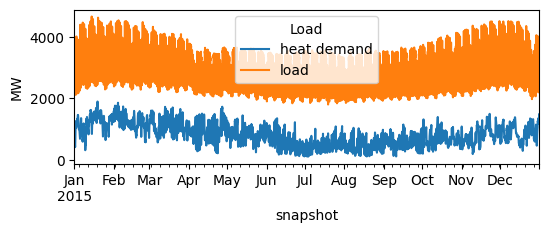

In [39]:
# load electricity demand data
df_heat = pd.read_csv('data/heat_demand.csv', sep=';', index_col=0) # in MWh
df_heat.index = pd.to_datetime(df_heat.index) #change index to datatime
country='IRL'

network.add("Bus",
    "heat bus",
    carrier="heat",
    overwrite=True)

# add load to the bus
network.add("Load",
    "heat demand",
    bus="heat bus",
    p_set=df_heat[country].values*0.2,
    overwrite=True)
network.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

network.add("Link", 
    "heat pump",
    carrier="heat pump",
    bus0="electricity bus",
    bus1="heat bus",
    p_nom_extendable=True,
    #p_nom_max=500,
    capital_cost=costs.at["central air-sourced heat pump", "capital_cost"]*0.1,  # €/MWe/a
    efficiency = cop(temp).values, #change with COP values
    overwrite=True)



In [40]:
objective_with_heatpump, capacities_HP, loadConsumption, generation_HP, snapshot, status = optimizer("2015",2950000)
links_hp = network.links[["p_nom_opt"]].copy()
# After heat pump only optimization
heat_hp_only = -network.links_t.p1['heat pump'].sum()

Index(['Hydro pump', 'Ireland - Britain', 'Ireland - France', 'heat pump'], dtype='object', name='Link')
Index(['electricity bus Britain', 'electricity bus France', 'heat bus',
       'electricity bus'],
      dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 73.86it/s]
INFO:linopy.io: Writing time: 0.75s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-wf8jsptw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-wf8jsptw.lp


Reading time = 0.29 seconds


INFO:gurobipy:Reading time = 0.29 seconds


obj: 315388 rows, 140175 columns, 635127 nonzeros


INFO:gurobipy:obj: 315388 rows, 140175 columns, 635127 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140175 primals, 315388 duals
Objective: 1.86e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


In [41]:
# Add carriers
network.add("Carrier", "CHP")  # name of the technology

# Add buses
network.add("Bus", "gas bus", carrier="gas")

# Add CHP link
network.add("Link",
            "CHP",
            bus0="gas bus",
            bus1="electricity bus",
            bus2="heat bus",
            carrier="CHP",
            efficiency=0.4,     # electrical efficiency
            efficiency2=0.4,    # thermal efficiency
            marginal_cost=80,   # fuel cost per MWh_th input
            capital_cost=costs.at["decentral CHP", "capital_cost"],
            p_nom_extendable=True,
            p_nom_max=1000,
            overwrite=True)


Index(['CHP'], dtype='object')

In [42]:
objective_with_heatpump_and_CHP, capacities_CHP, loadConsumption, generation_CHP, snapshot, status = optimizer("2015",2950000)
links_hp_chp = network.links[["p_nom_opt"]].copy()



Index(['Hydro pump', 'Ireland - Britain', 'Ireland - France', 'heat pump'], dtype='object', name='Link')
Index(['electricity bus Britain', 'electricity bus France', 'heat bus',
       'electricity bus'],
      dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 68.56it/s]
INFO:linopy.io: Writing time: 0.8s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-7z5t8u7b.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-7z5t8u7b.lp


Reading time = 0.33 seconds


INFO:gurobipy:Reading time = 0.33 seconds


obj: 341670 rows, 148936 columns, 687689 nonzeros


INFO:gurobipy:obj: 341670 rows, 148936 columns, 687689 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 148936 primals, 341670 duals
Objective: 1.86e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


In [43]:
print(f"Objective (Heat pump only):     €{objective_with_heatpump:,.0f}")
print(f"Objective (Heat pump + CHP):    €{objective_with_heatpump_and_CHP:,.0f}")


Objective (Heat pump only):     €1,859,363,345
Objective (Heat pump + CHP):    €1,859,363,345


In [44]:
#Compare capacities before and after heat system
print(capacities)
print(capacities_CHP)

Generator
onshorewind Britain     328.0000
onshorewind France      618.0000
onshorewind            4784.8000
solar                     0.0000
OCGT                   3437.1536
Coal                      0.0000
Biomass                  70.0000
Oil                     645.6778
offshorewind              0.0000
Name: p_nom_opt, dtype: float64
Generator
onshorewind Britain     328.000000
onshorewind France      618.000000
onshorewind            4784.800000
solar                   740.000000
OCGT                   3988.600878
Coal                      0.000000
Biomass                  70.000000
Oil                     798.883243
offshorewind             25.200000
Name: p_nom_opt, dtype: float64


In [45]:


# Step 0: Rename columns to match desired labels
rename_map = {
    'onshorewind': 'Onshore Wind',
    'solar': 'Solar',
    'OCGT': 'Gas (OCGT)',
    'Coal': 'Coal',
    'Biomass': 'Biomass',
    'Oil': 'Oil',
    'offshorewind': 'Offshore Wind',
    'onshorewind Britain': 'Import from Britain',
    'onshorewind France': 'Import from France', 
    'storage_generation': 'Storage generation',
    
}
generation_renamed = generation_CHP.rename(columns=rename_map)

# Pie chart data
color_map = {
    'Onshore Wind': 'blue',
    'Solar': 'orange',
    'Gas (OCGT)': 'brown',
    'Coal': 'grey',
    'Biomass': 'green',
    'Oil': 'black',
    'Offshore Wind': 'purple',
    'Import from Britain': 'lightblue',
    'Import from France': 'lightgreen', 
    'Storage generation': 'red'
}
colors = list(color_map.values())
labels = list(color_map.keys())
sizes = [generation_renamed[col].sum() for col in labels]

# Create pie chart
fig = go.Figure(
    data=[go.Pie(
        labels=labels,
        values=sizes,
        marker=dict(colors=colors),
        showlegend=True
    )]
)

# Update layout
fig.update_layout(
    #title="Electricity Mix",
    height=700,
    width=900,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=0.5,
        xanchor="center",
        x=1.5
    )
)

# Show and export
fig.show()
fig.write_image("Plots/electricity_mix_G.pdf", format="pdf", width=600, height=500)

* Missing the COP for heat pump
* Missing extension to the country links maybe
* How do we know if the CHP is producing heat or electricity
* What should the marginal price of CHP be?
* Check at capital cost for CHP er korrekt (på nette evt.)

In [46]:
print(f"Installed CHP capacity: {network.links.at['CHP', 'p_nom_opt']} MW")


Installed CHP capacity: 0.0 MW


In [47]:
total_el = network.links_t.p1["CHP"].sum()  # MWh
total_heat = network.links_t.p2["CHP"].sum()  # MWh
total_gas = -network.links_t.p0["CHP"].sum()  # MWh_th

print(f"CHP electricity generated: {total_el:.0f} MWh")
print(f"CHP heat generated: {total_heat:.0f} MWh")
print(f"CHP gas consumed: {total_gas:.0f} MWh_th")


CHP electricity generated: 0 MWh
CHP heat generated: 0 MWh
CHP gas consumed: -0 MWh_th


<Axes: title={'center': 'Electricity'}>

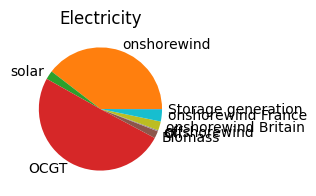

In [48]:
pd.concat([-network.links_t.p1['CHP'], network.generators_t.p], axis=1).sum().plot.pie(figsize=(6, 2), title='Electricity')


<Axes: title={'center': 'Heat'}>

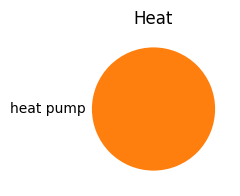

In [49]:
pd.concat([-network.links_t.p2['CHP'],-network.links_t.p1['heat pump']], axis=1).sum().plot.pie(figsize=(6, 2), title='Heat')


# H)

In [50]:
def optimizer_H(year, co2_limit=None, limit=None):

    network_h = pypsa.Network()
    
    if co2_limit is not None:
        network_h.add("GlobalConstraint",
                    "co2_limit",
                    type="primary_energy",
                    carrier_attribute="co2_emissions",
                    sense="<=",
                    constant=co2_limit,
                    overwrite=True)
    hours_in_year = pd.date_range(f'{year}-01-01 00:00Z',
                                f'{year}-12-31 23:00Z',
                                freq='h')
    




    network_h.set_snapshots(hours_in_year.values)

    network_h.add("Bus",
                "electricity bus", overwrite=True)

    # load electricity demand data
    df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
    df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
    country='IRL'
    print(df_elec[country].head())

    # add load to the bus
    network_h.add("Load",
        "load",
        bus="electricity bus",
        p_set=df_elec[country].values,
        overwrite=True)
    

    # add the different carriers, only gas emits CO2
    network_h.add("Carrier", "gas", co2_emissions= costs.at["gas", "CO2 intensity"], overwrite=True) # in t_CO2/MWh_th
    network_h.add("Carrier", "onshorewind", overwrite=True)
    network_h.add("Carrier", "solar", overwrite=True)
    network_h.add("Carrier", "coal", co2_emissions = costs.at["coal", "CO2 intensity"], overwrite=True) # in t_CO2/MWh_th
    network_h.add("Carrier", "biomass", co2_emissions = costs.at["biomass", "CO2 intensity"], overwrite=True) # in t_CO2/MWh_th
    network_h.add("Carrier", "oil", co2_emissions = costs.at["oil", "CO2 intensity"], overwrite=True) # in t_CO2/MWh_th
    network_h.add("Carrier", "offshorewind", overwrite=True)

    # add onshore wind generator
    df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
    df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
    CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network_h.snapshots]]
    network_h.add("Generator",
                "onshorewind",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="onshorewind",
                p_nom_max=4810-25.2, # maximum capacity can be limited due to environmental constraints. Based on electricity maps - minus the off shore wind capacity
                capital_cost =costs.at["onwind", "capital_cost"] , # in €/MW
                marginal_cost = 0,
                p_max_pu = CF_wind.values,
                overwrite=True)

    # add solar PV generator
    df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
    df_solar.index = pd.to_datetime(df_solar.index)
    CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network_h.snapshots]]
    network_h.add("Generator",
                "solar",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="solar",
                p_nom_max = 740, # maximum capacity can be limited due to environmental constraints Based on electricity maps
                capital_cost = costs.at["solar", "capital_cost"], # in €/MW
                marginal_cost = 0,
                p_max_pu = CF_solar.values,
                overwrite=True)

    # add OCGT (Open Cycle Gas Turbine) generator
    network_h.add("Generator",
                "OCGT",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="gas",
                p_nom_max=4270*limit, #based on electricity maps
                capital_cost = costs.at["OCGT", "capital_cost"], #in €/MW
                marginal_cost = costs.at["OCGT", "marginal_cost"],
                efficiency = costs.at["OCGT", "efficiency"],
                overwrite=True)

    # add Coal generator
    network_h.add("Generator",
                "Coal",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="coal",
                p_nom_max=920, #based on electricity maps
                capital_cost = costs.at["coal", "capital_cost"], #in €/MW
                marginal_cost = costs.at["coal", "marginal_cost"],
                overwrite=True)

    # add biomass generator
    network_h.add("Generator",
                "Biomass",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="biomass",
                p_nom_max=70, #based on electricity maps 
                capital_cost = costs.at["biomass", "capital_cost"], #in €/MW
                marginal_cost = costs.at["biomass", "marginal_cost"],
                overwrite=True)

    # add oil generator
    network_h.add("Generator",
                "Oil",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="oil",
                p_nom_max=830, #based on electricity maps
                capital_cost = costs.at["oil", "capital_cost"], #in €/MW
                marginal_cost = costs.at["oil", "marginal_cost"],
                overwrite=True)

    # add offshore wind generator
    df_offshorewind = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
    df_offshorewind.index = pd.to_datetime(df_offshorewind.index)
    CF_offshorewind = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network_h.snapshots]]
    network_h.add("Generator",
                "offshorewind",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="offshorewind",
                p_nom_max=25.2, # maximum capacity can be limited due to environmental constraints. #Ireland doesnt have offshore wind today, but are proposing to install 5GW soon
                capital_cost = costs.at["offwind", "capital_cost"], # in €/MW
                marginal_cost = 0,
                p_max_pu = CF_offshorewind.values,
                overwrite=True)
    

    cable_length_Ireland_Britain = 160 # in km based on the actial green link cable
    p_nom_cable_britain = 500
    p_nom_onshore_britain = 32800

    #Adding international links
    network_h.add("Bus",
                "electricity bus Britain",
                carrier="electricity",
                overwrite=True)


    network_h.add("Generator",
                "onshorewind Britain",
                bus="electricity bus Britain",
                p_nom_extendable=True,
                carrier="onshorewind",
                p_nom_max=p_nom_onshore_britain*0.01, # maximum capacity can be limited due to environmental constraints. Based on electricity maps - minus the off shore wind capacity
                #capital_cost = costs.at["onwind", "capital_cost"], # in €/MW  # exclude capital cost because it is not part of the system
                marginal_cost = 0,
                p_max_pu = CF_wind_GBR.values,
                overwrite=True)


    network_h.add("Link",
                'Ireland - Britain',
                bus0="electricity bus",
                bus1="electricity bus Britain",
                p_nom_extendable=True, # capacity is optimised
                p_nom_max=p_nom_cable_britain, # maximum capacity can be limited due to environmental constraints. Based on electricity maps - minus the off shore wind capacity
                p_min_pu=-1,
                length=cable_length_Ireland_Britain, # length (in km) between country a and country b
                capital_cost=400*cable_length_Ireland_Britain, 
                overwrite=True) # capital cost * length
    

    cable_length_Ireland_France = 575 # in km based on the actial link Celtic interconnector

    p_nom_cable_france = 700
    p_nom_onshore_france = 61800

    network_h.add("Bus",
                    "electricity bus France",
                    carrier="electricity",
                    overwrite=True)


    network_h.add("Generator",
                "onshorewind France",
                bus="electricity bus France",
                p_nom_extendable=True,
                carrier="onshorewind",
                p_nom_max=p_nom_onshore_france*0.01,
                #capital_cost = costs.at["onwind", "capital_cost"], # in €/MW # exclude capital cost because it is not part of the system
                marginal_cost = 0,
                p_max_pu = CF_wind_FRA.values,
                overwrite=True)


    network_h.add("Link",
                'Ireland - France',
                bus0="electricity bus",
                bus1="electricity bus France",    
                p_nom_extendable=True, # capacity is optimised
                p_nom_max = p_nom_cable_france,
                p_min_pu=-1,
                length=cable_length_Ireland_France, # length (in km) between country a and country b
                capital_cost=400*cable_length_Ireland_France, 
                overwrite = True) # capital cost * length



    




    #Optimization
    status = network_h.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0, "DualReductions": 0})


    objective = network_h.objective
    capacities = network_h.generators.p_nom_opt #in MW
    loadConsumption = network_h.loads_t.p
    generation = network_h.generators_t.p
    snapshots = network_h.snapshots
    
    
    
    

    return objective, capacities, loadConsumption, generation, snapshots, status, network_h


In [51]:
objective_h, capacities_h, loadConsumption_h, generation_h, snapshot_h, status_h, network_h = optimizer_H("2015", 3975000, 0.6)


utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['Ireland - Britain', 'Ireland - France'], dtype='object', name='Link')
Index(['electricity bus', 'electricity bus Britain', 'electricity bus France'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
 - DualReductions: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 60.85it/s]
INFO:linopy.io: Writing time: 0.51s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-10-16


Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-i54blxm9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/j2/tx7xgp1d11n3lnbvkls0cjsw0000gn/T/linopy-problem-i54blxm9.lp


Reading time = 0.21 seconds


INFO:gurobipy:Reading time = 0.21 seconds


obj: 219023 rows, 96371 columns, 442402 nonzeros


INFO:gurobipy:obj: 219023 rows, 96371 columns, 442402 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96371 primals, 219023 duals
Objective: 2.32e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


In [52]:
generation_sum = generation_h.sum(axis=0)
generation_sum

Generator
onshorewind            1.155444e+07
solar                  6.440344e+05
OCGT                   2.146894e+06
Coal                   4.453957e+06
Biomass                5.178340e+05
Oil                    5.555942e+06
offshorewind           5.072725e+04
onshorewind Britain    5.674558e+05
onshorewind France     1.080984e+06
dtype: float64

In [53]:
#plot electricity mix
# Step 0: Rename columns to match desired labels
rename_map = {
    'onshorewind': 'Onshore Wind',
    'solar': 'Solar',
    'OCGT': 'Gas (OCGT)',
    'Coal': 'Coal',
    'Biomass': 'Biomass',
    'Oil': 'Oil',
    'offshorewind': 'Offshore Wind',
    'onshorewind Britain': 'Import from Britain',
    'onshorewind France': 'Import from France', 
}
generation_renamed = generation_h.rename(columns=rename_map)
# Pie chart data
color_map = {
    'Onshore Wind': 'blue',
    'Solar': 'orange',
    'Gas (OCGT)': 'brown',
    'Coal': 'grey',
    'Biomass': 'green',
    'Oil': 'black',
    'Offshore Wind': 'purple',
    'Import from Britain': 'lightblue',
    'Import from France': 'lightgreen', 
}
colors = list(color_map.values())
labels = list(color_map.keys())
sizes = [generation_renamed[col].sum() for col in labels]
# Create pie chart
fig = go.Figure(
    data=[go.Pie(
        labels=labels,
        values=sizes,
        marker=dict(colors=colors),
        showlegend=True
    )]
)
# Update layout
fig.update_layout(
    #title="Electricity Mix",
    height=700,
    width=900,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=0.5,
        xanchor="center",
        x=1.5
    )
)
# Show and export
fig.show()
fig.write_image("Plots/electricity_mix_H.pdf", format="pdf", width=600, height=500)